In [1]:
# 0. Runtime check / install
# (Colab already has CUDA + PyTorch; just ensure correct torch version)
!nvidia-smi
import torch, torchvision
print("torch", torch.__version__, "cuda:", torch.cuda.is_available())


Sat Oct  4 07:21:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# 1. Imports
import math, time, os, random
from functools import partial
from pathlib import Path
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets


In [3]:
# 2. Config (edit for best run)
class Cfg:
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 256   # lower if OOM
    epochs = 30
    lr = 3e-4
    weight_decay = 0.05
    image_size = 32
    patch_size = 4     # patch 4x4 -> 8x8 patches for 32x32 images (non-overlapping)
    emb_dim = 256
    depth = 8
    num_heads = 8
    mlp_ratio = 4
    dropout = 0.0
    grad_clip = 1.0
cfg = Cfg()


In [4]:
# 3. Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything(cfg.seed)


In [5]:
# 4. Data (CIFAR-10) transforms & loaders
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR10(root="data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# 5. ViT model (simple, clear, compliant with requirements)
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256):
        super().__init__()
        assert img_size % patch_size == 0
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: B, C, H, W -> B, embed_dim, H/ps, W/ps
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # B, num_patches, embed_dim
        return x

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, in_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio), dropout=dropout)

    def forward(self, x):
        # x: B, N, dim
        x2 = self.norm1(x)
        attn_out, _ = self.attn(x2, x2, x2)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=256, depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        self.blocks = nn.ModuleList([
            EncoderBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        # init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            pass

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)             # B, N, D
        cls_tokens = self.cls_token.expand(B, -1, -1)  # B,1,D
        x = torch.cat((cls_tokens, x), dim=1)         # B, N+1, D
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls = x[:, 0]
        out = self.head(cls)
        return out


In [7]:
# 6. Create model, optimizer, scheduler, loss
model = ViT(img_size=cfg.image_size, patch_size=cfg.patch_size, embed_dim=cfg.emb_dim,
            depth=cfg.depth, num_heads=cfg.num_heads, mlp_ratio=cfg.mlp_ratio, dropout=cfg.dropout).to(cfg.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
# simple cosine annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
criterion = nn.CrossEntropyLoss()
print(model)


ViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x EncoderBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
# 7. Training & evaluation loops
def train_one_epoch(model, loader, opt, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        if cfg.grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        pbar.set_description(f"loss: {running_loss/total:.4f} acc: {100*correct/total:.2f}%")
    return running_loss/total, correct/total

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return correct/total


In [9]:
# 8. Run training
best_acc = 0.0
save_path = "best_vit.pth"
for epoch in range(cfg.epochs):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, cfg.device)
    test_acc = evaluate(model, test_loader, cfg.device)
    scheduler.step()
    epoch_time = time.time() - t0
    print(f"Epoch {epoch+1}/{cfg.epochs}  train_acc={train_acc:.4f}  test_acc={test_acc:.4f}  time={epoch_time:.1f}s")
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_path)
        print("Saved new best:", best_acc)
print("Best test acc:", best_acc)


loss: 1.8261 acc: 32.81%: 100%|██████████| 196/196 [00:54<00:00,  3.62it/s]


Epoch 1/30  train_acc=0.3281  test_acc=0.4128  time=57.8s
Saved new best: 0.4128


loss: 1.4582 acc: 46.58%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 2/30  train_acc=0.4658  test_acc=0.4828  time=59.9s
Saved new best: 0.4828


loss: 1.3108 acc: 52.46%: 100%|██████████| 196/196 [00:55<00:00,  3.54it/s]


Epoch 3/30  train_acc=0.5246  test_acc=0.5386  time=59.1s
Saved new best: 0.5386


loss: 1.2091 acc: 56.31%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 4/30  train_acc=0.5631  test_acc=0.5831  time=59.7s
Saved new best: 0.5831


loss: 1.1426 acc: 58.55%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 5/30  train_acc=0.5855  test_acc=0.6112  time=59.9s
Saved new best: 0.6112


loss: 1.0810 acc: 60.94%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 6/30  train_acc=0.6094  test_acc=0.6190  time=59.7s
Saved new best: 0.619


loss: 1.0356 acc: 62.65%: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Epoch 7/30  train_acc=0.6265  test_acc=0.6391  time=60.2s
Saved new best: 0.6391


loss: 0.9886 acc: 64.51%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 8/30  train_acc=0.6451  test_acc=0.6588  time=60.0s
Saved new best: 0.6588


loss: 0.9471 acc: 65.79%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 9/30  train_acc=0.6579  test_acc=0.6644  time=60.1s
Saved new best: 0.6644


loss: 0.9016 acc: 67.72%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 10/30  train_acc=0.6772  test_acc=0.6855  time=59.7s
Saved new best: 0.6855


loss: 0.8668 acc: 68.97%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 11/30  train_acc=0.6897  test_acc=0.6807  time=59.8s


loss: 0.8334 acc: 70.07%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 12/30  train_acc=0.7007  test_acc=0.6905  time=60.0s
Saved new best: 0.6905


loss: 0.7914 acc: 71.94%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 13/30  train_acc=0.7194  test_acc=0.6969  time=59.7s
Saved new best: 0.6969


loss: 0.7593 acc: 72.92%: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]


Epoch 14/30  train_acc=0.7292  test_acc=0.7181  time=60.0s
Saved new best: 0.7181


loss: 0.7278 acc: 73.98%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 15/30  train_acc=0.7398  test_acc=0.7234  time=59.8s
Saved new best: 0.7234


loss: 0.6932 acc: 75.20%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 16/30  train_acc=0.7520  test_acc=0.7313  time=60.1s
Saved new best: 0.7313


loss: 0.6578 acc: 76.29%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 17/30  train_acc=0.7629  test_acc=0.7255  time=59.6s


loss: 0.6333 acc: 77.35%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 18/30  train_acc=0.7735  test_acc=0.7393  time=59.9s
Saved new best: 0.7393


loss: 0.5968 acc: 78.80%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 19/30  train_acc=0.7880  test_acc=0.7404  time=59.8s
Saved new best: 0.7404


loss: 0.5653 acc: 79.78%: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


Epoch 20/30  train_acc=0.7978  test_acc=0.7444  time=59.8s
Saved new best: 0.7444


loss: 0.5336 acc: 80.96%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 21/30  train_acc=0.8096  test_acc=0.7517  time=59.8s
Saved new best: 0.7517


loss: 0.5128 acc: 81.70%: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Epoch 22/30  train_acc=0.8170  test_acc=0.7558  time=60.2s
Saved new best: 0.7558


loss: 0.4852 acc: 82.55%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 23/30  train_acc=0.8255  test_acc=0.7472  time=59.7s


loss: 0.4601 acc: 83.43%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 24/30  train_acc=0.8343  test_acc=0.7566  time=60.0s
Saved new best: 0.7566


loss: 0.4408 acc: 84.28%: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 25/30  train_acc=0.8428  test_acc=0.7588  time=59.7s
Saved new best: 0.7588


loss: 0.4261 acc: 84.90%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 26/30  train_acc=0.8490  test_acc=0.7575  time=59.9s


loss: 0.4131 acc: 85.25%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 27/30  train_acc=0.8525  test_acc=0.7614  time=60.1s
Saved new best: 0.7614


loss: 0.3968 acc: 85.99%: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


Epoch 28/30  train_acc=0.8599  test_acc=0.7609  time=59.9s


loss: 0.3920 acc: 86.00%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 29/30  train_acc=0.8600  test_acc=0.7604  time=59.9s


loss: 0.3891 acc: 86.21%: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 30/30  train_acc=0.8621  test_acc=0.7613  time=59.9s
Best test acc: 0.7614


In [10]:
# 9. Quick evaluation printing classwise accuracy (optional)
from collections import defaultdict
model.load_state_dict(torch.load(save_path))
model.eval()
class_correct = [0]*10
class_total = [0]*10
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(cfg.device); labels = labels.to(cfg.device)
        logits = model(imgs)
        preds = logits.argmax(1)
        for p,l in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            class_total[l]+=1
            if p==l: class_correct[l]+=1
for i in range(10):
    print(f"class {i}: {100.*class_correct[i]/class_total[i]:.2f}%")


class 0: 77.90%
class 1: 85.40%
class 2: 66.70%
class 3: 58.90%
class 4: 71.90%
class 5: 71.70%
class 6: 85.30%
class 7: 78.70%
class 8: 85.30%
class 9: 79.60%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


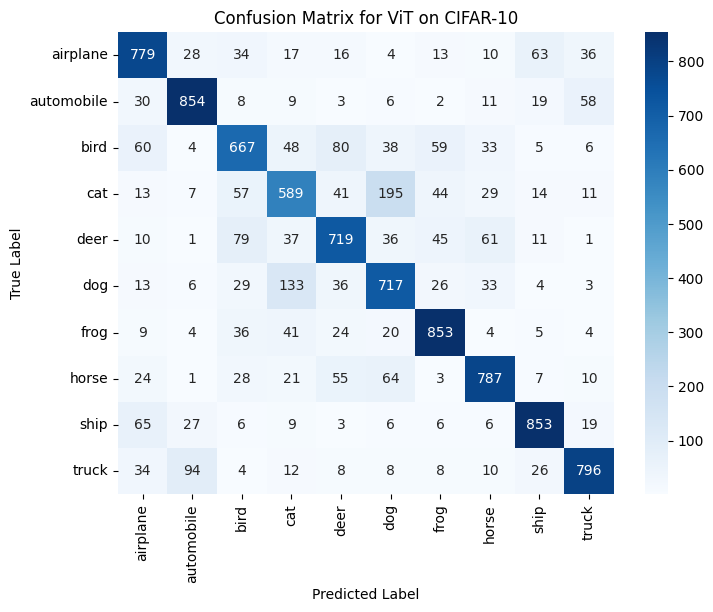


Classification Report:

              precision    recall  f1-score   support

    airplane       0.75      0.78      0.76      1000
  automobile       0.83      0.85      0.84      1000
        bird       0.70      0.67      0.68      1000
         cat       0.64      0.59      0.61      1000
        deer       0.73      0.72      0.72      1000
         dog       0.66      0.72      0.68      1000
        frog       0.81      0.85      0.83      1000
       horse       0.80      0.79      0.79      1000
        ship       0.85      0.85      0.85      1000
       truck       0.84      0.80      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Collect all predictions and true labels ---
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(cfg.device)
        labels = labels.to(cfg.device)
        logits = model(imgs)
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

# Try to get class names (if dataset has them)
try:
    class_names = test_loader.dataset.classes
except AttributeError:
    class_names = [str(i) for i in range(10)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ViT on CIFAR-10")
plt.show()

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))
